**Вариант 8**

Исследуемую СМО можно изобразить следующим графом:

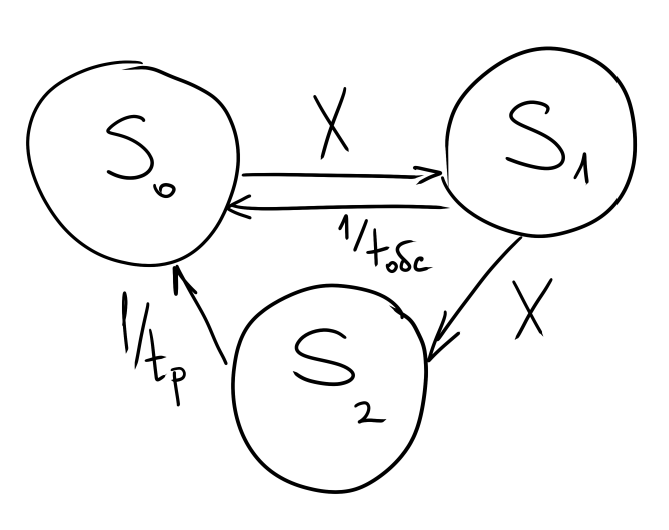

1.   Состояние 0: система свободна и готова к обслуживанию.
2.   Состояние 1: система занята (обслуживает заявку).
3.   Состояние 2: система неисправна и находится в ремонте.

Найдём теоретические характеристики СМО. Найдём финальные вероятности состояний, решив систему диффренциальных уравнений:
\begin{cases}
      \frac{dp_0}{dt}=-Xp_0+\frac{1}{t_{обс}}p_1+\frac{1}{t_р}p_2,\\
      \frac{dp_1}{dt}=Xp_0-\frac{1}{t_{обс}}p_1-\frac{1}{t_р}p_2,\\
      \frac{dp_2}{dt}=Xp_1-\frac{1}{t_r}p_2,
\end{cases}
с нормировочным условием $$ p_0+p_1+p_2=1. $$
Поскольку финальные вероятности по определению не зависят от времени при $$ t \rightarrow \infty,$$
заменим все дифференциалы на нули, получив систему алгебраических уравнений, в которую добавим нормировочное условие. Первое и второе уравнения линейно зависимы, потому исключим одно из них. Итоговая система имеет вид: 
\begin{gather}
\begin{bmatrix}
-X & \frac{1}{t_{обс}} & \frac{1}{t_р}\\
0 & X & \frac{1}{t_р}\\ 
1 & 1 & 1
\end{bmatrix}
\begin{bmatrix}
p_0\\
p_1\\ 
p_2
\end{bmatrix}
=
\begin{bmatrix}
0\\
0\\ 
1
\end{bmatrix}
\end{gather}
Её решим аналитическим методом обратной матрицы.

Следуя семантике определения пропусной способности, определим отказ в обслуживании для конкретной заявки как её поступление в то время, когда система находится в состояних 1 или 2. Тогда $$p_{отк} = p_1+p_2$$ по закону объединения несовместных событий.

Относительная пропусная способность: $$ Rel=p_{обс}=1-p_{отк}=p_0,$$
абсолютная пропусная способность: $$ Abs=X*Rel=Xp_0.$$


Число обслуженных заявок в общем понимании СМО в данной системе представляет собой число заявок, которые были приняты на обслуживание, то есть число переходов состояний 0 -> 2.

Результаты моделирования приведены ниже.

In [2]:
import numpy as np
from numpy.linalg import inv
from math import log

class Timeline:
    def __init__(self, time_step):
        self.time = 0
        self.time_step = time_step
        self.current_state = 0
        self.history = [0]
        self.disc_history = [0]

    def calculate_deltatime(self, intens):
        return - 1 / intens * log(np.random.uniform(0, 1))

    def progress(self, deltatime, statistics):
        self.time += deltatime
        occurences = int(self.time / self.time_step) - len(self.history) + 1
        appendix = [self.current_state] * occurences
        statistics.state_history += appendix
        for _ in range(occurences):
            last_time = self.history[-1]
            self.history.append(last_time + self.time_step)
        self.disc_history.append(self.time)

class Statistics:
    def __init__(self):
        self.state_history = [0]
        self.served_count = 0
        self.total_count = 0
        self.state_counts = [1, 0, 0]
        self.disc_state_history = [0]
        self.reject_counts = 0


duration = 5000
X, Y, Z = 2, 3, 4
t_obs = 1 / Y
t_r = 1 / Z
step = 1

timeline = Timeline(step)
statistics = Statistics()

print(f'Starting simulation with params X={X}, t_obs={t_obs}, t_r={t_r}')
print(f' for {duration} time units with step {step}')

while timeline.time < duration:
    if timeline.current_state == 0:
        delta_to_1 = timeline.calculate_deltatime(X)
        timeline.progress(delta_to_1, statistics)
        timeline.current_state = 1
        statistics.total_count += 1
    elif timeline.current_state == 1:
        delta_to_0 = timeline.calculate_deltatime(1 / t_obs)
        delta_to_2 = timeline.calculate_deltatime(X)
        if delta_to_2 >= delta_to_0:
            timeline.progress(delta_to_0, statistics)
            timeline.current_state = 0
            statistics.served_count += 1

            buffer_time = timeline.calculate_deltatime(X)
            while buffer_time < delta_to_0:
                statistics.reject_counts += 1
                statistics.total_count += 1
                buffer_time += timeline.calculate_deltatime(X)
        else:
            timeline.progress(delta_to_2, statistics)
            timeline.current_state = 2

            buffer_time = timeline.calculate_deltatime(X)
            while buffer_time < delta_to_2:
                statistics.reject_counts += 1
                statistics.total_count += 1
                buffer_time += timeline.calculate_deltatime(X)
    elif timeline.current_state == 2:
        delta_to_0 = timeline.calculate_deltatime(1 / t_r)
        timeline.progress(delta_to_0, statistics)
        timeline.current_state = 0
        buffer_time = timeline.calculate_deltatime(X)
        while buffer_time < delta_to_0:
            statistics.reject_counts += 1
            statistics.total_count += 1
            buffer_time += timeline.calculate_deltatime(X)
    else:
        raise Exception('Illegal state')
    statistics.state_counts[timeline.current_state] += 1
    statistics.disc_state_history.append(timeline.current_state)


def count_occur(item, arr):
    count = 0
    for el in arr:
        if el == item:
            count += 1
    return count


print('Empirical characteristics:')
state_count = len(statistics.state_history)
print(f'1) Final probability p0 = {count_occur(0, statistics.state_history) / state_count}')
print(f'2) Final probability p1 = {count_occur(1, statistics.state_history) / state_count}')
print(f'3) Final probability p2 = {count_occur(2, statistics.state_history) / state_count}')
print(f'4) Abs throughput = {(statistics.total_count - statistics.reject_counts) / timeline.time}')
print(f'5) Rel throughput = {(statistics.total_count - statistics.reject_counts) / statistics.total_count}')

print('Theoretical characteristics:')
p = inv(np.array([
    [-X, 1 / t_obs, 1 / t_r],
    [0, X, -1 / t_r],
    [1, 1, 1]
])).dot(np.array([[0], [0], [1]]))
print(f'1) Final probability p0 = {p[0]}')
print(f'2) Final probability p1 = {p[1]}')
print(f'3) Final probability p2 = {p[2]}')
print(f'4) Abs throughput = {X * p[0]}')
print(f'5) Rel throughput = {p[0]}')


Starting simulation with params X=2, t_obs=0.3333333333333333, t_r=0.25
 for 5000 time units with step 1
Empirical characteristics:
1) Final probability p0 = 0.6294741051789642
2) Final probability p1 = 0.2513497300539892
3) Final probability p2 = 0.1191761647670466
4) Abs throughput = 1.2521202178163204
5) Rel throughput = 0.6230470693601353
Theoretical characteristics:
1) Final probability p0 = [0.625]
2) Final probability p1 = [0.25]
3) Final probability p2 = [0.125]
4) Abs throughput = [1.25]
5) Rel throughput = [0.625]
